In [1]:
#Python data ecosystem (NumPy, Pandas, Matplotlib, etc.)
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
from matplotlib import ticker
import datetime as dt
from time import strptime

#Open given json file 
#ref: https://stackoverflow.com/questions/48614158/read-json-file-as-pandas-dataframe
file = open('transaction-data-adhoc-analysis.json')
given_data = json.load(file)

#Load json data into data frame
df = pd.DataFrame(given_data)

###FIRST TABLE: items sold per month

##CLEAN DATA
#Use split function 'transaction_items' to separate different products in each transation based on ";" then use explode function to arrange data
#ref: https://www.w3schools.com/python/ref_string_split.asp
#ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html
df['transaction_items'] = df['transaction_items'].str.split(';')
df = df.explode('transaction_items')

#Use split function to separate information of each product ordered: brand name, name of product, and quantitiy
item_info = df['transaction_items'].str.split(',',expand = True)
df['Brand Name'] = item_info[0]
df['Name of Product'] = item_info[1]
df['Quantity'] = item_info[2]
df = df.reset_index()

df.drop(columns = ['transaction_items','index','address','birthdate','mail','sex','username'],inplace = True)

#Change 'transaction_date' from variable into date 
#ref: https://stackoverflow.com/questions/58332445/need-to-convert-word-month-into-number-from-a-table
df['transaction_date'] = df['transaction_date'].astype('datetime64[ns]')
df['Month'] = df['transaction_date'].dt.month

#Use extract function to get quantity from "(x'number')"
#ref: https://www.geeksforgeeks.org/python-pandas-series-str-extract/
df['Quantity'] = df['Quantity'].str.extract('(\d+)',expand=False).astype(int)

#Make first pivot table
#Ref: https://www.youtube.com/watch?v=ZUFmdsgvDts
items_sold = df.pivot_table(values='Quantity',index=['Name of Product'],columns='Month',aggfunc='sum')

display(items_sold)

Month,1,2,3,4,5,6
Name of Product,,,,,,
Beef Chicharon,9665,10001,9816,9890,10028,9902
Gummy Vitamins,9681,9980,10145,9842,9948,9980
Gummy Worms,9559,9996,9986,10043,9801,9934
Kimchi and Seaweed,9676,9949,9967,9921,9773,10104
Nutrional Milk,9727,9691,9876,9786,9881,9767
Orange Beans,9774,10037,9611,9914,9964,10106
Yummy Vegetables,9959,10256,9896,9861,9735,9722


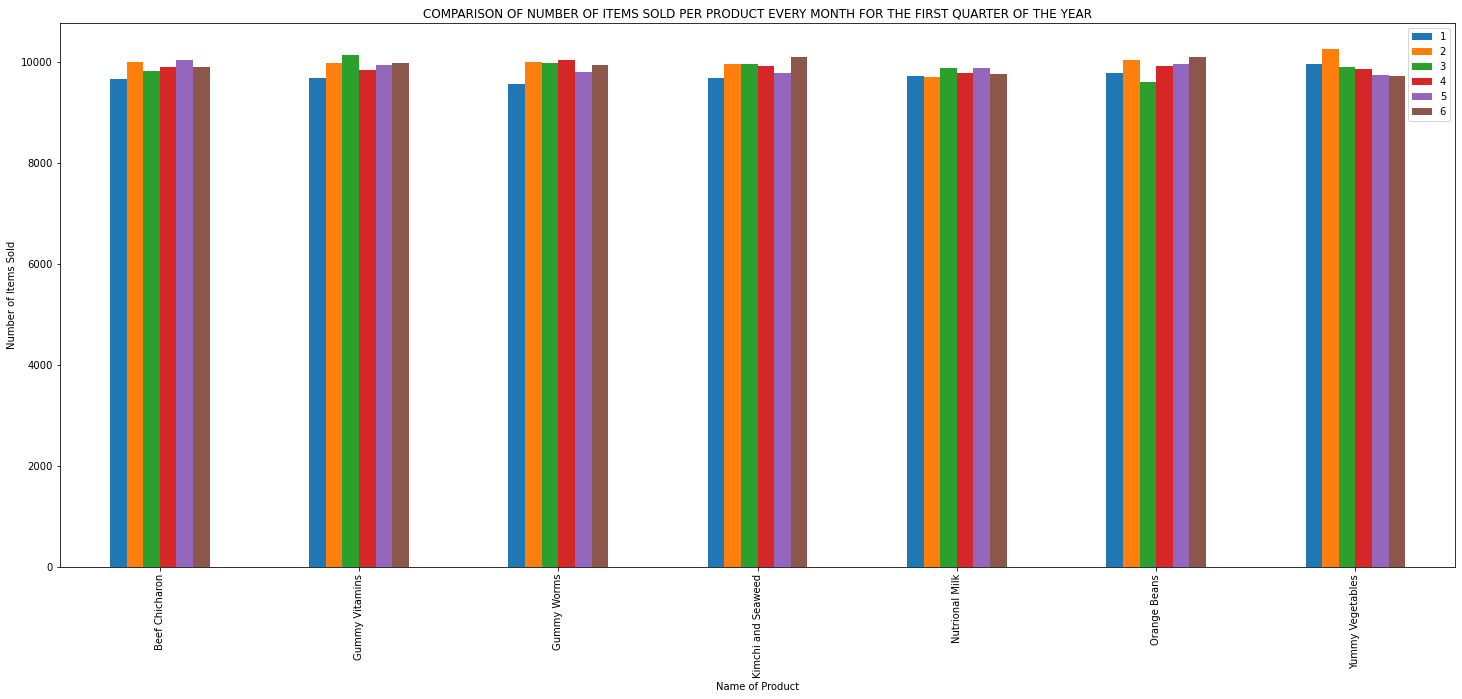

In [2]:
###FIRST BAR GRAPH: items sold per month

#Plot pivot table using a bar graph
#Ref: https://www.youtube.com/watch?v=1h0LvhDg9NA
items_sold.plot(kind='bar', figsize=(25, 10))

plt.xlabel('Name of Product')
plt.ylabel('Number of Items Sold')
plt.title('COMPARISON OF NUMBER OF ITEMS SOLD PER PRODUCT EVERY MONTH FOR THE FIRST QUARTER OF THE YEAR')
plt.legend(loc='upper right')
plt.show()

In [3]:
###SECOND TABLE: total sale value per item per month

orig_df = pd.DataFrame(given_data)

#isolate and get the transaction information of the items and their quantity
transactions = orig_df[['transaction_items','transaction_value']]

#get the number of transactions that only has one product
#split
single_product = transactions['transaction_items'].str.contains(';')==False
single_product_trans = transactions[single_product]
#then get transactions that only has one quantity
quantity_one = single_product_trans['transaction_items'].str.contains('x1')==True
quantity_one_transactions = single_product_trans[quantity_one]

#get remaining transactions
#drop duplicates
unique_quantity_one_transactions = quantity_one_transactions.drop_duplicates(subset='transaction_value')
unique_quantity_one_transactions = unique_quantity_one_transactions.reset_index()
unique_quantity_one_transactions.drop(columns = ['index'],inplace=True)

#split like in first table
uqot_info = unique_quantity_one_transactions['transaction_items'].str.split(',',expand=True)
unique_quantity_one_transactions['Brand Name'] = uqot_info[0]
unique_quantity_one_transactions['Name of Product'] = uqot_info[1]
unique_quantity_one_transactions['Quantity'] = uqot_info[2]
unique_quantity_one_transactions.drop(columns = ['transaction_items','Quantity'],inplace=True)

#make pivot table
grouped_df = df.groupby(['Name of Product','Month'])
new_grouped_df = grouped_df['Quantity'].sum().reset_index()
total_sales = new_grouped_df.merge(unique_quantity_one_transactions, on='Name of Product', how='left')
condition = total_sales.Quantity * total_sales.transaction_value
total_sales['Total Sales'] = condition

total_sales_pivot = total_sales.pivot_table(values = 'Total Sales',index = 'Name of Product',columns = 'Month')

display(total_sales_pivot)

Month,1,2,3,4,5,6
Name of Product,,,,,,
Beef Chicharon,12554835,12991299,12750984,12847110,13026372,12862698
Gummy Vitamins,14521500,14970000,15217500,14763000,14922000,14970000
Gummy Worms,1433850,1499400,1497900,1506450,1470150,1490100
Kimchi and Seaweed,7731124,7949251,7963633,7926879,7808627,8073096
Nutrional Milk,19356730,19285090,19653240,19474140,19663190,19436330
Orange Beans,1945026,1997363,1912589,1972886,1982836,2011094
Yummy Vegetables,4979500,5128000,4948000,4930500,4867500,4861000


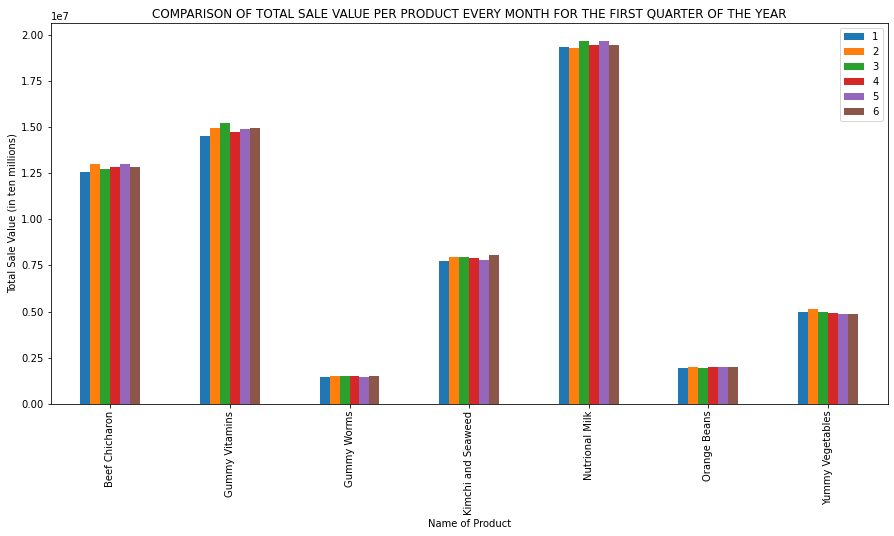

In [4]:
###SECOND BAR GRAPH: total sale value per item per month
#Ref: https://www.youtube.com/watch?v=1h0LvhDg9NA
total_sales_pivot.plot(kind='bar', figsize=(15, 7),title='COMPARISON OF TOTAL SALE VALUE PER PRODUCT EVERY MONTH FOR THE FIRST QUARTER OF THE YEAR')
plt.xlabel('Name of Product')
plt.ylabel('Total Sale Value (in ten millions)')
plt.legend(loc='upper right')
plt.show()

In [5]:
###THIRD TABLE: number of customers who are repeaters, inactive, and engaged

#Repeaters - the number of customers from the current month who also purchased in the previous month. This metric is 0 for the earliest month in the transactional data.
#Inactive - the number of customers in the total set of transactions up to and including the current month who have purchase history but do not have a purchase for the current month. This metric is 0 for the earliest month in the transactional data.
#Engaged - the number of customers in the total set of transactions up to and including the current month who have consistently purchased every single month'

months_list = [1,2,3,4,5,6]

##Make a truth table
#Repeaters - customers from the current month who also purchased in the previous month.
#Inactive - customers who have purchase history but do not have a purchase for the current month.
#Engaged - customers who have consistently purchased every single month

#Make a truth table
#Ref: https://stackoverflow.com/questions/50765199/i-need-to-make-a-truth-table-from-pandas-dataframe-based-on-values-on-a-column
i, r = pd.factorize(df.name)
j, c = pd.factorize(df.transaction_date.dt.month)
b = np.zeros((r.size, c.size), int)
b[i, j] = 1

customer_df = pd.DataFrame(b, r, c)
customer = pd.DataFrame() 
months = []

#make values for the truth table
#monthly customers
for i in set(df.transaction_date.dt.month):
    months.append(i)
    total = customer_df[months].sum(axis=1)
    customer[i] = total

#define repeater customers
#check if they ordered in the previous and current month
repeaters_list = [0]
for i in set(df.transaction_date.dt.month):
    try:
        repeaters_list.append(len(customer_df.loc[(customer_df[i]+customer_df[i+1] == 2)]))
    except KeyError:
        break

#define inactive customers
#check if they ordered in the previous but didn't in current month by looking if the number of orders isn't the same as the number of month
inactive_list = [0]
for i in set(df.transaction_date.dt.month):
    try:
        inactive_list.append(len(customer.loc[(customer[i+1] == customer[i]) & (customer[i] > 0)]))
    #when it reaches an error which is when it reaches the 6th month, the for loop breaks
    except KeyError:
        break
        
#define engaged customers
#like inactive but number of times must be equal to number of month
engaged_list = []
for i in set(df.transaction_date.dt.month):
    engaged_list.append(len(customer.loc[customer[i] == i]))
        
#put into a dataframe
customer_metrics = []
customer_metrics.append(repeaters_list)
customer_metrics.append(inactive_list)
customer_metrics.append(engaged_list)

customer_activity = pd.DataFrame(customer_metrics, columns = ['January', 'February', 'March', 'April', 'May', 'June'], index =['Repeaters','Inactive','Engaged'])
display(customer_activity)

,January,February,March,April,May,June
Repeaters,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,4126,3289,2667,2190


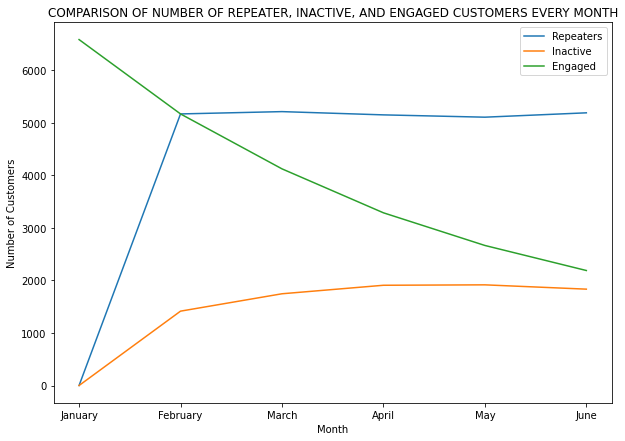

In [6]:
###LINE GRAPH: number of customers who are repeaters, inactive, and engaged
#Use transpose function to change the value of x-axis from kinds of customers to months
transpose = customer_activity.transpose()
#Plot
#Ref: https://www.youtube.com/watch?v=P4F3PzCMrtk
transpose.plot(kind='line', figsize=(10, 7), title='COMPARISON OF NUMBER OF REPEATER, INACTIVE, AND ENGAGED CUSTOMERS EVERY MONTH')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.legend(loc='upper right')
plt.show()
plt.show()